In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import time
import imageio.v3 as iio
import pandas as pd
import os
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras

# Neural Network Models

After an initial and not really successful exploration with simpler models, we will now focus on training neural networks to classify SETI signals from spectrogram images.
Neural networks are highly effective machine learning models capable of capturing complex patterns in data, making them well-suited for the analysis of SETI signals, which often contain intricate and noisy patterns.
To classify these SETI signals, we will employ deep learning techniques leveraging some of the most prominent architectures in image classification, such as Convolutional Neural Networks (CNNs). Additionally, we will explore custom-designed architectures tailored specifically for this task.

In this multi-class image classification problem, the goal is to train a model that can correctly identify the class of each SETI signal. There are seven distinct signal types, and the model must learn to classify each input image into one of these seven categories based on the unique characteristics of the spectrogram data.

Each class is represented with an index followed by the class named:
~~~
class_names = ["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]
~~~

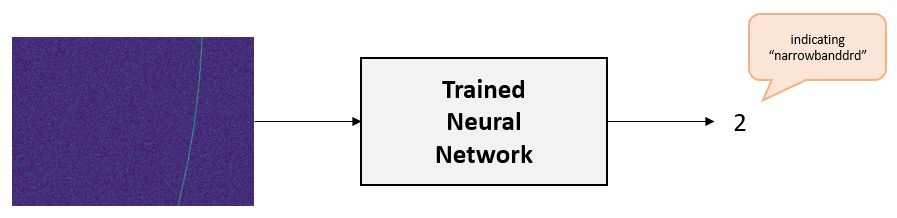


A neural network has several hidden layers to extract (â€œlearnâ€) features from the images. The very last layer is the one that classifies the image. In this case, we are classifying seven classes (seven signal types). Therefore the last layer has seven neurons, one for each type.
And because we want to know what type of signal is represented, we use softmax activation in the last layer to give us a probability distribution of each type.

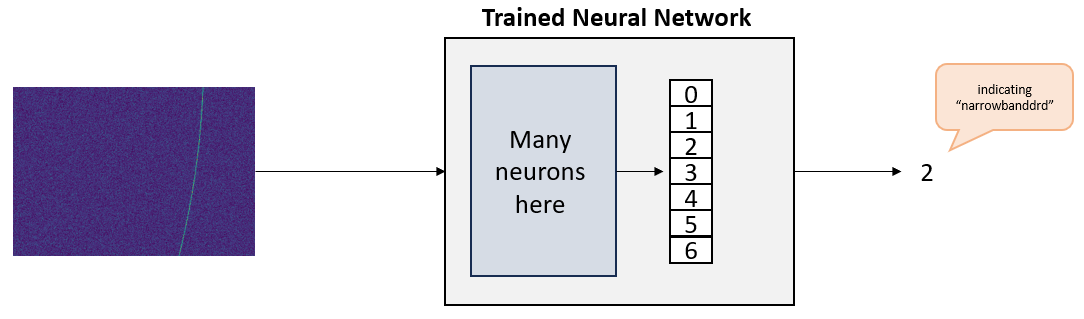


## Custom Models

Talk about `ImageDataGenerator` https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Data Preparation
# Load and preprocess your dataset


def get_generated_data(base_path='/kaggle/input/seti-data', data_aug=False, img_height=224, img_width=224, batch_size=32):
    train_data_dir = f'{base_path}/primary_small/train/'
    valid_data_dir = f'{base_path}/primary_small/valid/'
    test_data_dir = f'{base_path}/primary_small/test/'
    
    valid_data_gen = ImageDataGenerator(rescale=1.0/255)
    test_data_gen = ImageDataGenerator(rescale=1.0/255)
    if data_aug:
        train_data_gen = ImageDataGenerator(
            rescale=1.0/255,
            brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            channel_shift_range=20,
            vertical_flip=True,
        )
    else:
        train_data_gen = ImageDataGenerator(rescale=1.0/255)
        
    train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    valid_generator = valid_data_gen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = test_data_gen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return train_generator, valid_generator, test_generator


Before proceeding with our model training, we will introduce both **EarlyStopping** and **ReduceLROnPlateau**. Together, these callbacks can enhance the training process by preventing overfitting (through EarlyStopping) and allowing the model to adapt its learning rate dynamically for improved performance (through ReduceLROnPlateau).

The **EarlyStopping** callback is used to stop the training process when the model's performance on the validation set stops improving. This is particularly useful for preventing overfitting, where a model learns the training data too well but performs poorly on unseen data. Importantly, it also helps save time by halting the training when there is no improvement.

The **ReduceLROnPlateau** callback reduces the learning rate when a monitored metric has stopped improving. This can be particularly useful when the training process has plateaued, as a smaller learning rate may help the model fine-tune its weights and improve performance.

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [4]:
def plot_predictions(model, test_generator, amount=7, images_per_row=4, class_names=["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]):
    # Get the first batch
    first_batch = test_generator.__getitem__(0)

    # Extract images and labels
    X_first, y_first = first_batch[0], first_batch[1]

    # Get predictions
    predictions = model.predict(X_first)

    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate the number of rows needed
    num_rows = amount // images_per_row + (amount % images_per_row != 0)
    
    # Plot the specified number of samples
    plt.figure(figsize=(20, num_rows * 4))

    # Adjust layout for padding
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    for i in range(amount):
        plt.subplot(num_rows, images_per_row, i + 1)
        
        # Display the image
        plt.imshow(X_first[i])
        
        # Get the predicted and actual class
        predicted_label = predicted_classes[i]
        true_label = np.argmax(y_first[i])
        
        # Set title and labels
        title = f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}"
        plt.title(title)
        plt.axis("off")

    plt.show()

In [5]:
def plot_losses(history):
    # Visualize training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss',linestyle='dashed')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

In [6]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matix(model, test_generator, class_names=["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]):
    # Confusion Matrix
    test_preds = model.predict(test_generator)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_true_classes = test_generator.classes
    cm = confusion_matrix(test_true_classes, test_preds_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[i] for i in range(7)], yticklabels=[class_names[i] for i in range(7)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
from sklearn.metrics import classification_report

def print_classifiaciton_report(model, test_generator):
    test_preds = model.predict(test_generator)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_true_classes = test_generator.classes
    
    report = classification_report(test_true_classes, test_preds_classes, output_dict=True)

    # Convert the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Optional: Round the metrics to 2 decimal places for better readability
    report_df = report_df.round(2)

    # Display the DataFrame
    print(report_df)

## Transfer Learning
One of the most effective strategies for improving the performance of neural network models is transfer learning. This method involves leveraging a pre-trained model as a starting point and fine-tuning it on a new dataset tailored for a specific task. By utilizing the knowledge and features learned by the pre-trained model, we can accelerate the training process, enhance the modelâ€™s performance, and achieve better results for our application.

For our implementation, at first we are utilizing the ImageNet dataset, a large and comprehensive collection of over 14 million images across more than 20,000 categories. ImageNet is renowned for its high-quality, diverse images, making it an excellent resource for training deep learning models. Models pre-trained on ImageNet have already learned rich feature representations, which are crucial for effective image analysis.

In the context of our SETI task, which involves classifying signals into 7 distinct classes, leveraging pre-trained models is especially beneficial. The complexity and diversity of the signals require a model that can effectively extract features and recognize patterns across multiple classes. Transfer learning allows us to utilize the extensive feature representations learned from ImageNet, which can translate well to the nuances in our SETI dataset.

For our transfer learning process, we will utilize some pre-trained models and proceed with fine-tuning. We will load the chosen base model and replace the final fully connected layer with a new layer that outputs the 7 classes relevant to our task.
In Addition, we will unfreeze some of the last layers for some fine-tuning to better adapt to our dataset. 
By focusing on the final layers, we ensure that the model is specifically tuned for distinguishing between the 7 classes of SETI signals.

At first we will start with **ResNet50** which is widely used for various computer vision tasks, including image classification.


In [8]:
train_generator, valid_generator, test_generator = get_generated_data()

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# Load the ResNet50 model with pretrained weights from ImageNet
# Exclude the top layers (include_top=False) to add custom layers for your task
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

94765736/94765736 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 3s 0us/step


The model will consist of an input layer following with the ResNet50 model, then a layer of GlobalAveragePooling2D as it helps maintain the number of parameters manageable, followed by a ReLU activation function, a BatchNormalization layer, and finally a softmax in the output layer of the model. 
We will use the `categorical_crossentropy` loss function to measures the dissimilarity between the true class labels and the predicted probabilities generated by the model, and the Adam optimizer to update the models parameters during training.

In [10]:
resnet50_model = Sequential([
    Input((224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'), 
    BatchNormalization(),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet50_model.summary()

Model: "sequential"

â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”³â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”³â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”“
â”ƒ Layer (type)                    â”ƒ Output Shape           â”ƒ       Param # â”ƒ
â”¡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â•‡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â•‡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”©
â”‚ resnet50 (Functional)           â”‚ (None, 7, 7, 2048)     â”‚    23,587,712 â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ global_average_pooling2d        â”‚ (None, 2048)           â”‚             0 â”‚
â”‚ (GlobalAveragePooling2D)        â”‚                        â”‚               â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ dense (Dense)                   â”‚ (None, 2048)           â”‚     4,196,352 â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ batch_normalization             â”‚ (None, 2048)           â”‚         8,192 â”‚
â”‚ (BatchNormalization)            â”‚                        â”‚               â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ dense_1 (Dense)                 â”‚ (None, 7)              â”‚        14,343 â”‚
â””â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”´â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”´â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”˜

 Total params: 27,806,599 (106.07 MB)

 Trainable params: 8,680,455 (33.11 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

In [11]:
start_time = time.time()

history = resnet50_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727940666.655980      88 service.cc:145] XLA service 0x7d16d80020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727940666.656037      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 9s 58ms/step - accuracy: 0.0781 - loss: 1.9634  

I0000 00:00:1727940673.272507      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 122s 586ms/step - accuracy: 0.3376 - loss: 1.7171 - val_accuracy: 0.1429 - val_loss: 4.0796 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 62s 342ms/step - accuracy: 0.4174 - loss: 1.5424 - val_accuracy: 0.1429 - val_loss: 6.2261 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 63s 344ms/step - accuracy: 0.4334 - loss: 1.4703 - val_accuracy: 0.1957 - val_loss: 10.6403 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 63s 346ms/step - accuracy: 0.4737 - loss: 1.4170 - val_accuracy: 0.1429 - val_loss: 27.0683 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 63s 345ms/step - accuracy: 0.4871 - loss: 1.3920 - val_accuracy: 0.1500 - val_loss: 13.9726 - learning_rate: 5.0000e-05
Epoch 6/20
1

It seems that after only 5 epochs out of the 20 that were set the training stopped, as the validation loss didn't improve as well as the validation accuracy.

And altough the accuracy levels seem to be very bad, lets see the model in practice.

1/1 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 3s 3s/step


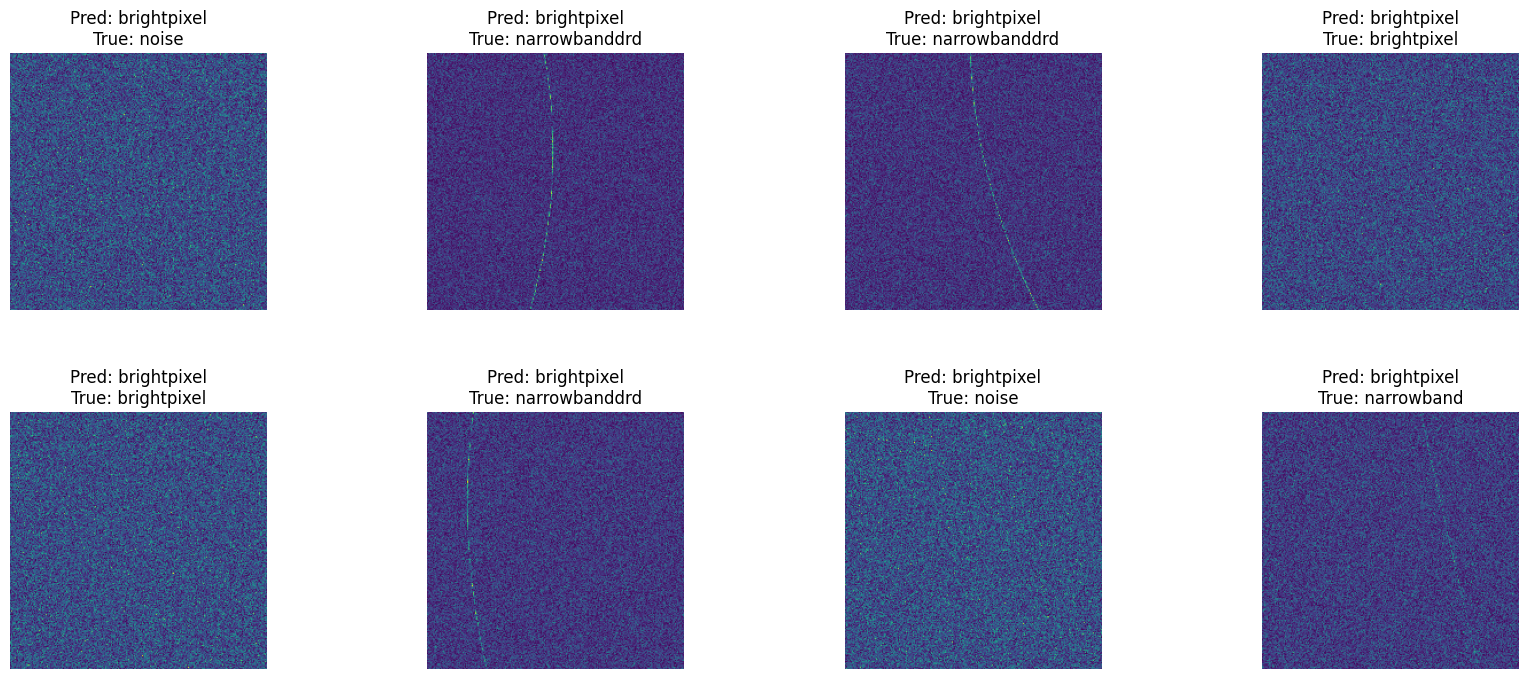

In [12]:
plot_predictions(model=resnet50_model, test_generator=test_generator, amount=8)

It looks like the model classifies all of the signals as `squiggle` which is of course not the case here.  
Lets try to understand what is going on here.

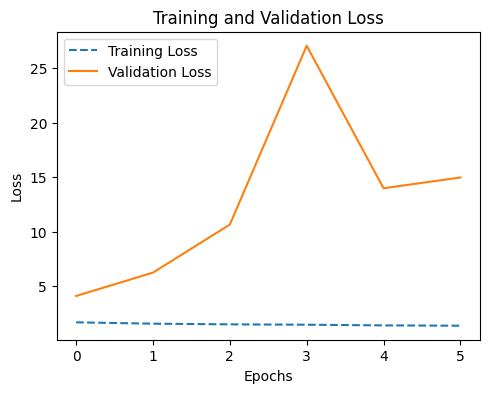

In [13]:
plot_losses(history)

We can see that the training loss is decreasing slightly in contrast to the validation loss that is just unstable and is increasing.  
This may indicate of an overfit in our model which we maybe need to look out for and fix.
But before that, we will check out a Confusion Matrix which provides a deeper insight into our model's performance as it allows us to see if our model performs well for some classes but poorly for others or overall if and where our model gets confused.

22/22 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 17s 643ms/step


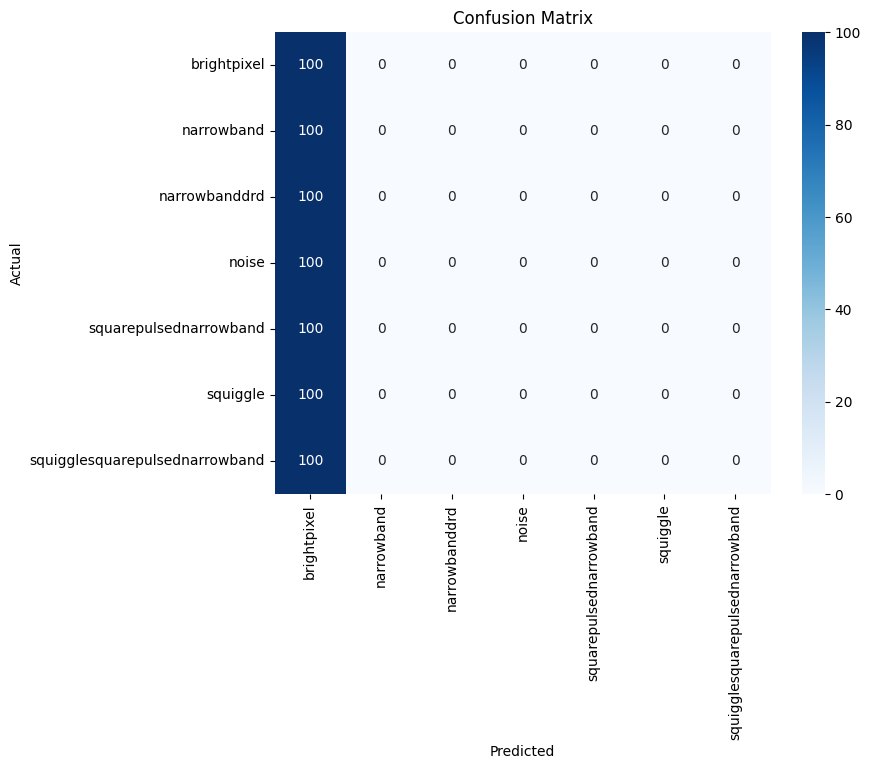

In [14]:
plot_confusion_matix(model=resnet50_model, test_generator=test_generator)

And as we have assumed before, the model classifies **ALL** of the signals as `squiggle`, and it seems like this model is just useless.  


In [15]:
print_classifiaciton_report(model=resnet50_model, test_generator=test_generator)

22/22 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 7s 310ms/step
              precision  recall  f1-score  support
0                  0.14    1.00      0.25   100.00
1                  0.00    0.00      0.00   100.00
2                  0.00    0.00      0.00   100.00
3                  0.00    0.00      0.00   100.00
4                  0.00    0.00      0.00   100.00
5                  0.00    0.00      0.00   100.00
6                  0.00    0.00      0.00   100.00
accuracy           0.14    0.14      0.14     0.14
macro avg          0.02    0.14      0.04   700.00
weighted avg       0.02    0.14      0.04   700.00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model's performance metrics are also very disappointing, we can undertand from the above report that our model seems to heavily favor class 5, achieving perfect recall for it, while failing completely on the other classes.  
So what's next? Before giving up on ResNet50 lets try something else, we will try to run the same model but now we will use data augmentation to exposed the model to more diverse training examples.

In [16]:
train_generator, valid_generator, test_generator = get_generated_data(data_aug=True)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


Now we will construct the model once again.

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# Load the ResNet50 model with pretrained weights from ImageNet
# Exclude the top layers (include_top=False) to add custom layers for your task
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

resnet50_model_with_data_aug = Sequential([
    Input((224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'), 
    BatchNormalization(),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
resnet50_model_with_data_aug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Let's train the model and hopefully it gets any better.

In [18]:
start_time = time.time()

history = resnet50_model_with_data_aug.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 89s 431ms/step - accuracy: 0.2892 - loss: 1.8489 - val_accuracy: 0.1429 - val_loss: 2.4807 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 74s 407ms/step - accuracy: 0.3544 - loss: 1.6965 - val_accuracy: 0.1429 - val_loss: 3.2786 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 74s 406ms/step - accuracy: 0.3682 - loss: 1.6378 - val_accuracy: 0.1429 - val_loss: 7.7061 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 73s 403ms/step - accuracy: 0.3802 - loss: 1.6135 - val_accuracy: 0.1429 - val_loss: 18.4405 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 74s 406ms/step - accuracy: 0.4035 - loss: 1.5881 - val_accuracy: 0.1714 - val_loss: 10.9268 - learning_rate: 5.0000e-05
Epoch 6/20
175

Unfortunatly from a glance on the results above it looks like this model is not any better.
But lets verify it both with visual representation of the predictions and some metrics.

1/1 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 3s 3s/step


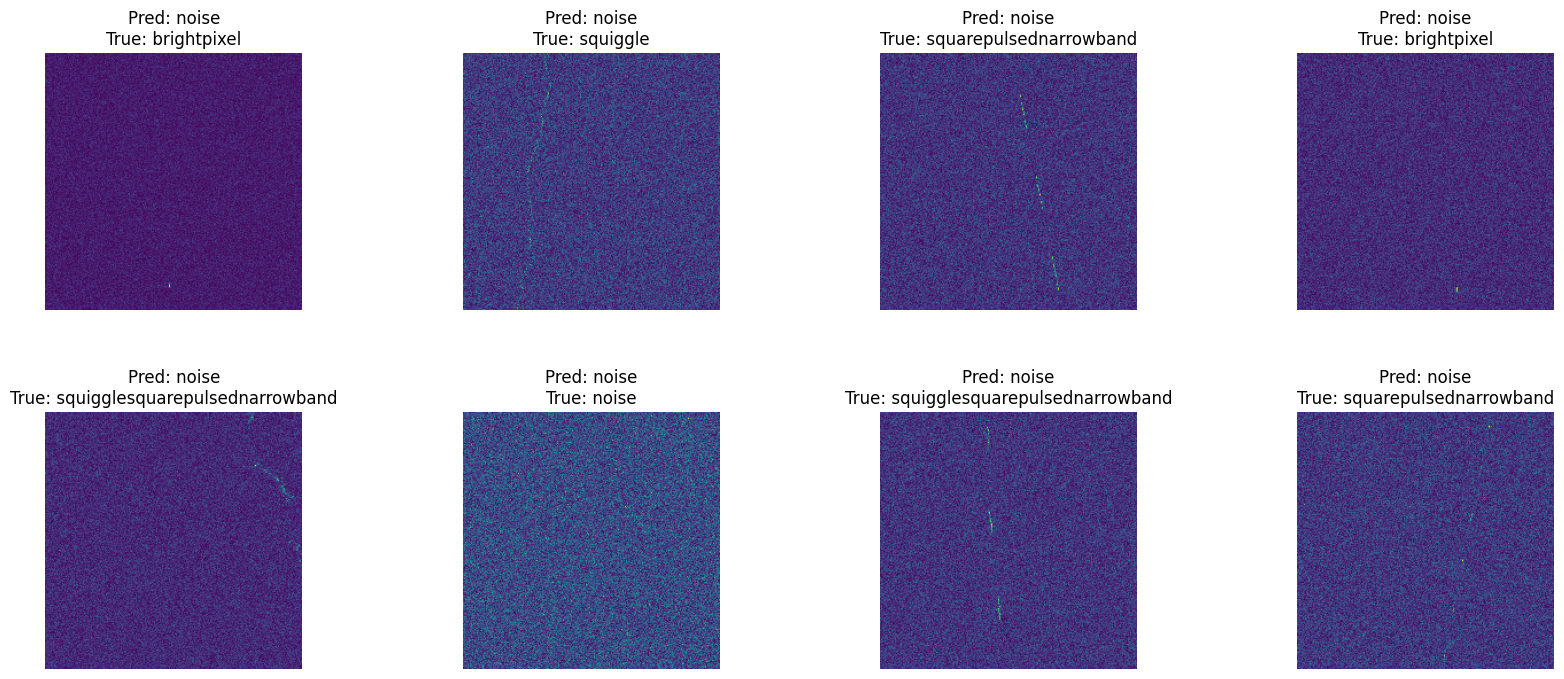

In [19]:
plot_predictions(model=resnet50_model_with_data_aug, test_generator=test_generator, amount=8)

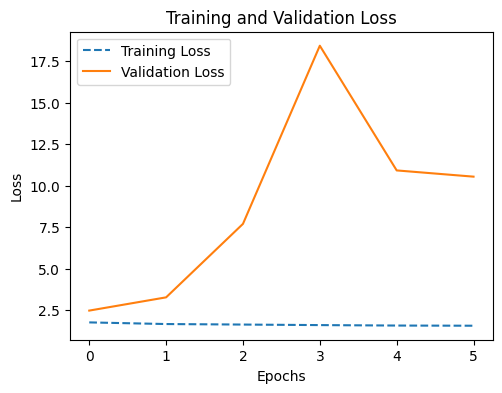

In [20]:
plot_losses(history)

22/22 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 12s 434ms/step


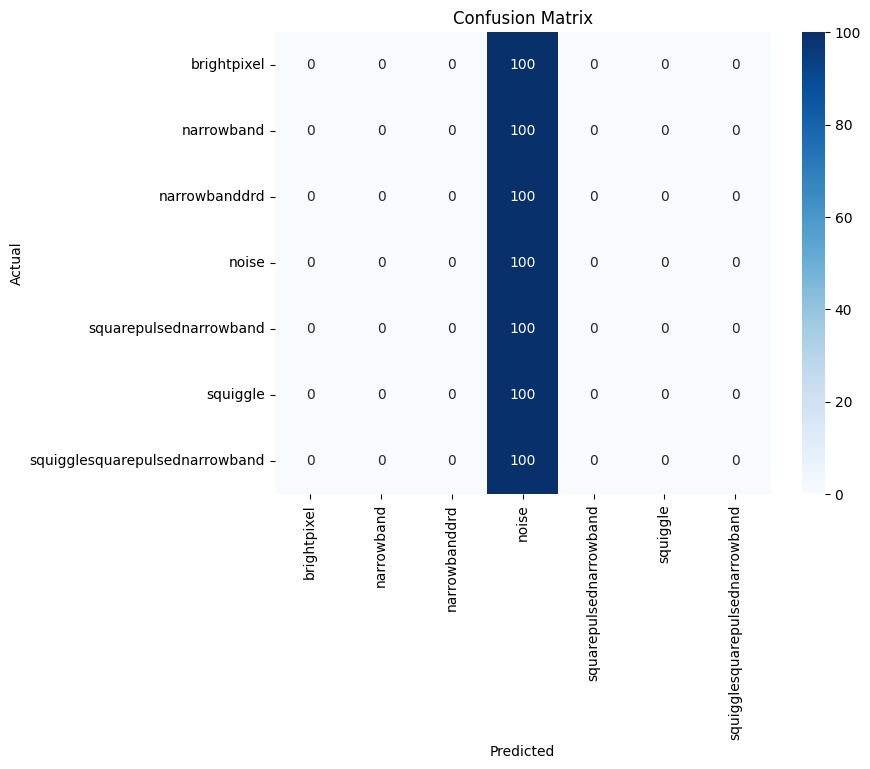

In [21]:
plot_confusion_matix(model=resnet50_model_with_data_aug, test_generator=test_generator)

In [22]:
print_classifiaciton_report(model=resnet50_model_with_data_aug, test_generator=test_generator)

22/22 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 7s 306ms/step
              precision  recall  f1-score  support
0                  0.00    0.00      0.00   100.00
1                  0.00    0.00      0.00   100.00
2                  0.00    0.00      0.00   100.00
3                  0.14    1.00      0.25   100.00
4                  0.00    0.00      0.00   100.00
5                  0.00    0.00      0.00   100.00
6                  0.00    0.00      0.00   100.00
accuracy           0.14    0.14      0.14     0.14
macro avg          0.02    0.14      0.04   700.00
weighted avg       0.02    0.14      0.04   700.00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So yeah... it didn't help. The issue could be either with our model or with the amount of data we train our model although we use data augmentation and that is because `ImageDataGenerator` doesn't actually adds additional data on top of the current training samples.

We have decided to reconsider the pre-trained models, and look into some models that are specifically tailored for time-series, e.g **WaveNet** or **VGGish**.  
For spectrogram classification or any task involving the analysis of spectrograms (like SETI signal detection), **VGGish** is likely a better choice because it is designed to work with Mel spectrograms (image-like representations of sound) while WaveNet, on the other hand, is more suited for generating and modeling raw audio sequences.

In [23]:
train_generator, valid_generator, test_generator = get_generated_data(data_aug=True)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pretrained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Define the input tensor
input_tensor = Input(shape=(224, 224, 3))

# Pass the input through the base model
x = base_model(input_tensor)

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
vgg16_model = Model(inputs=input_tensor, outputs=output)

# Compile the model
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
vgg16_model.summary()

58889256/58889256 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 2s 0us/step


Model: "functional_3"

â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”³â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”³â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”“
â”ƒ Layer (type)                    â”ƒ Output Shape           â”ƒ       Param # â”ƒ
â”¡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â•‡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â•‡â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”©
â”‚ input_layer_5 (InputLayer)      â”‚ (None, 224, 224, 3)    â”‚             0 â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ vgg16 (Functional)              â”‚ (None, 7, 7, 512)      â”‚    14,714,688 â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ global_average_pooling2d_2      â”‚ (None, 512)            â”‚             0 â”‚
â”‚ (GlobalAveragePooling2D)        â”‚                        â”‚               â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ dense_4 (Dense)                 â”‚ (None, 2048)           â”‚     1,050,624 â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ batch_normalization_2           â”‚ (None, 2048)           â”‚         8,192 â”‚
â”‚ (BatchNormalization)            â”‚                        â”‚               â”‚
â”œâ”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¼â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”¤
â”‚ dense_5 (Dense)                 â”‚ (None, 7)              â”‚        14,343 â”‚
â””â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”´â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”´â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”˜

 Total params: 15,787,847 (60.23 MB)

 Trainable params: 15,783,751 (60.21 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [25]:
start_time = time.time()

history = vgg16_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 106s 462ms/step - accuracy: 0.4557 - loss: 1.4214 - val_accuracy: 0.2457 - val_loss: 1.6296 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 79s 433ms/step - accuracy: 0.6503 - loss: 0.9307 - val_accuracy: 0.4600 - val_loss: 1.3528 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 77s 426ms/step - accuracy: 0.7011 - loss: 0.8401 - val_accuracy: 0.6529 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 77s 423ms/step - accuracy: 0.7265 - loss: 0.7470 - val_accuracy: 0.6257 - val_loss: 1.0608 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 76s 417ms/step - accuracy: 0.7371 - loss: 0.7328 - val_accuracy: 0.5771 - val_loss: 1.2675 - learning_rate: 1.0000e-04
Epoch 6/20
175/

In [26]:
!pip install shap


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
import shap

X_tr, y_tr = next(train_generator)  # Extract a batch of data
X_ts, y_ts = next(test_generator)  # Extract a batch of data

class_names = ["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]

masker = shap.maskers.Image("blur(128,128)", X_tr[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(vgg16_model, masker, output_names=class_names)
shap_values = explainer(X_tr[0:21], max_evals=513, batch_size=50, outputs=shap.Explanation.argsort.flip[:7])


  0%|          | 0/511 [00:00<?, ?it/s]

PartitionExplainer explainer: 22it [01:05,  3.10s/it]


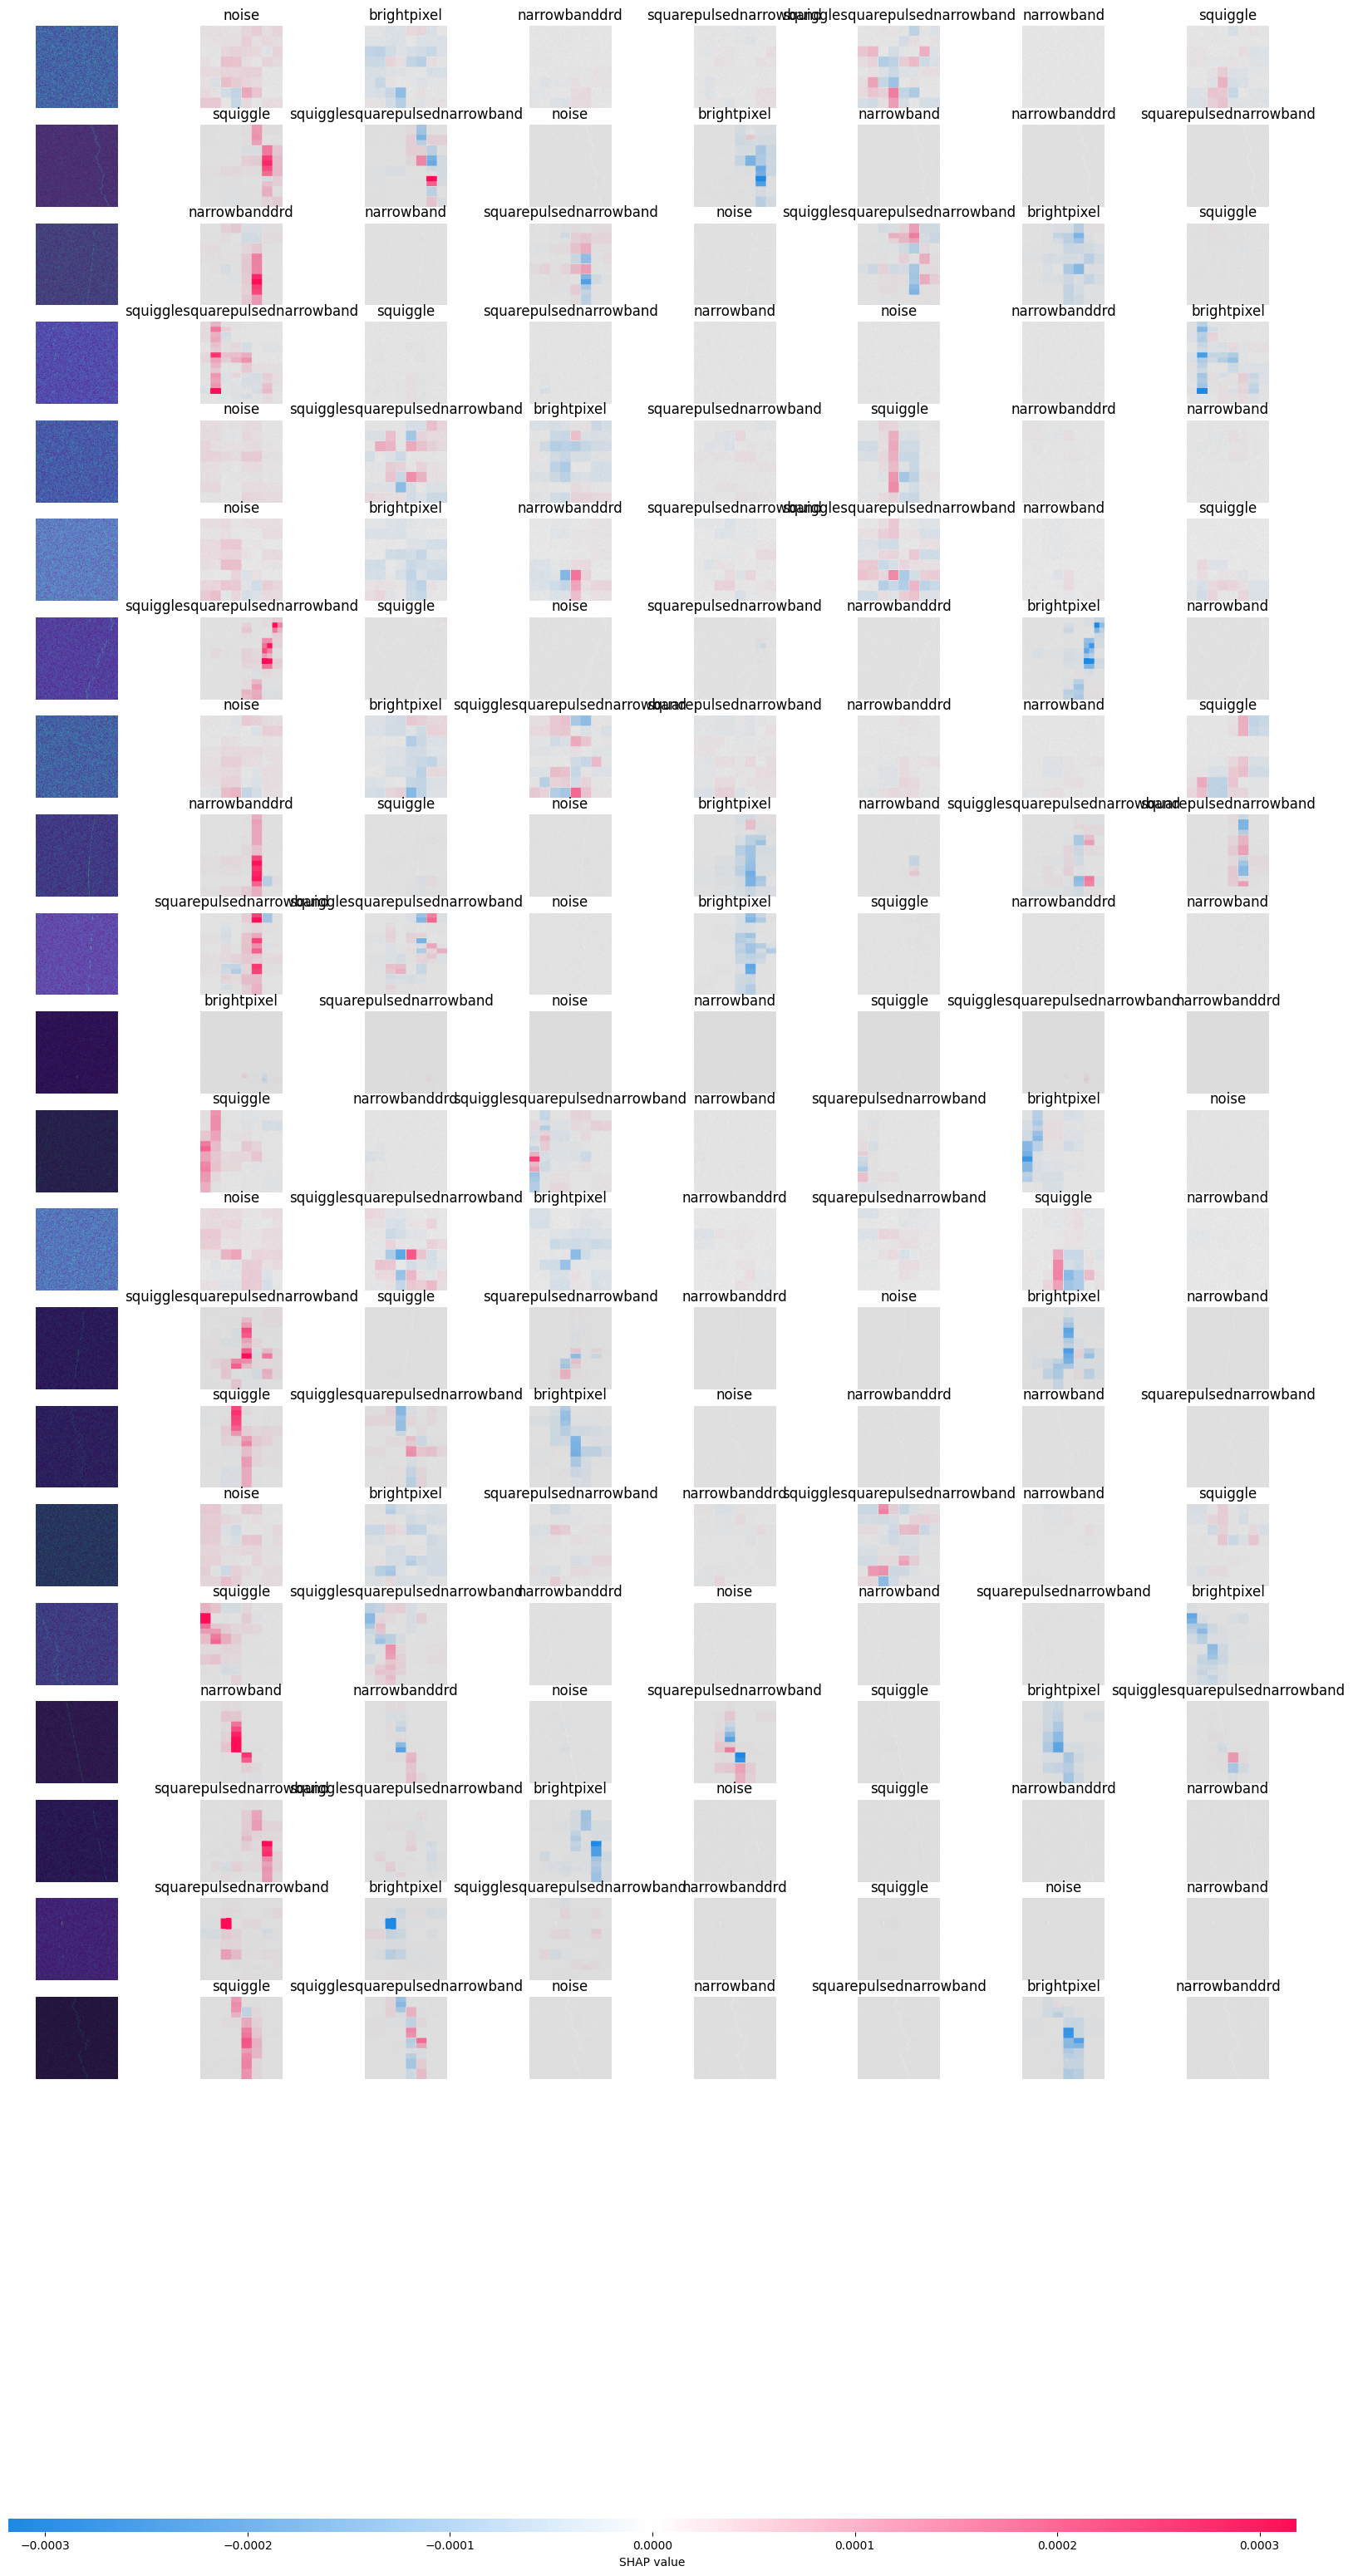

In [28]:
shap.image_plot(shap_values)


In [29]:
# L2 regularization, also known as weight decay, is a technique used in machine learning and deep learning to prevent overfitting and improve the generalization of a model. Here's why L2 regularization is important and how it works:

# If the model is indeed overfitting add:
#     from tensorflow.keras.regularizers import l2
    
# , kernel_regularizer=l2(0.001)  # Add L2 regularization
#     Dropout(0.5),